Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Jamie Pan"
COLLABORATORS = "None"

---

In [2]:
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine, text
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

### Data Collection

In [3]:
file_name = "NCHS_-_Leading_Causes_of_Death__United_States.csv"
df = pd.read_csv(file_name)

# Show first few rows to check if file has been successfully read
df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,United States,"169,936",49.4
1,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,"2,703",53.8
2,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,436,63.7
3,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,"4,184",56.2
4,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,"1,625",51.8


### Data Cleaning

In [4]:
# Drop the "113 Cause Name" column
df = df.drop("113 Cause Name", axis=1)

# Show first few rows to check if column has been successfully dropped
df.head()

,Year,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,Unintentional injuries,United States,"169,936",49.4
1,2017,Unintentional injuries,Alabama,"2,703",53.8
2,2017,Unintentional injuries,Alaska,436,63.7
3,2017,Unintentional injuries,Arizona,"4,184",56.2
4,2017,Unintentional injuries,Arkansas,"1,625",51.8


In [5]:
# Drop rows where there is null or missing values for "Deaths" column
df.dropna(subset=["Deaths"], inplace=True)

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Use forward fill for "Year", "Cause Name", and "State" columns
df["Year"] = df["Year"].ffill()
df["Cause Name"] = df["Cause Name"].ffill()
df["State"] = df["State"].ffill()

# Remove commas from "Deaths" and "Age-adjusted Death Rate" columns and convert them to numeric values
df["Deaths"] = df["Deaths"].str.replace(",", "")
df["Deaths"] = pd.to_numeric(df["Deaths"], errors="coerce")
df["Age-adjusted Death Rate"] = df["Age-adjusted Death Rate"].str.replace(",", "")
df["Age-adjusted Death Rate"] = pd.to_numeric(df["Age-adjusted Death Rate"])

# Show first few rows to check if data has been successfully cleaned
df.head()

,Year,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,Unintentional injuries,United States,169936,49.4
1,2017,Unintentional injuries,Alabama,2703,53.8
2,2017,Unintentional injuries,Alaska,436,63.7
3,2017,Unintentional injuries,Arizona,4184,56.2
4,2017,Unintentional injuries,Arkansas,1625,51.8


In [6]:
# Check that all columns do not have missing/null values
df.isna().sum()

Year                       0
Cause Name                 0
State                      0
Deaths                     0
Age-adjusted Death Rate    0
dtype: int64

In [7]:
# Save df into a SQLite database as a table
database_file = "leading_causes_of_death.db"
table_name = "US_Mortality_Rates"
engine = create_engine(f'sqlite:///{database_file}')
df.to_sql(table_name, con=engine, if_exists="replace", index=False)

10868

In [8]:
# Show first 5 rows of table to see if df has been successfully loaded
with engine.connect() as conn:
    result = conn.execute(text(f'SELECT * FROM {table_name} LIMIT 5'))
    for row in result:
        print(row)

(2017, 'Unintentional injuries', 'United States', 169936, 49.4)
(2017, 'Unintentional injuries', 'Alabama', 2703, 53.8)
(2017, 'Unintentional injuries', 'Alaska', 436, 63.7)
(2017, 'Unintentional injuries', 'Arizona', 4184, 56.2)
(2017, 'Unintentional injuries', 'Arkansas', 1625, 51.8)


In [9]:
# Delete rows where "State" is "United States"
delete_query = f"""
    DELETE FROM {table_name}
    WHERE "State" = 'United States';
    """
select_query = f"""
    SELECT * FROM {table_name}
    LIMIT 5
    """
with engine.connect() as conn:
    conn.execute(text(delete_query))
    conn.commit()
    result = conn.execute(text(select_query))
    for row in result:
        print(row)

(2017, 'Unintentional injuries', 'Alabama', 2703, 53.8)
(2017, 'Unintentional injuries', 'Alaska', 436, 63.7)
(2017, 'Unintentional injuries', 'Arizona', 4184, 56.2)
(2017, 'Unintentional injuries', 'Arkansas', 1625, 51.8)
(2017, 'Unintentional injuries', 'California', 13840, 33.2)


In [10]:
# Replace "CLRD" from "Cause Name" to "Chronic lower respiratory disease"
update_query = f"""
    UPDATE {table_name}
    SET "Cause Name" = 'Chronic lower respiratory disease'
    WHERE "Cause Name" = 'CLRD';
    """
select_query = f"""
    SELECT * 
    FROM {table_name}
    WHERE "Cause Name" = 'Chronic lower respiratory disease'
    LIMIT 5;
    """
with engine.connect() as conn:
    conn.execute(text(update_query))
    conn.commit()
    result = conn.execute(text(select_query))
    # Check that "CLRD" has been successfully replaced
    for row in result:
        print(row)

(2017, 'Chronic lower respiratory disease', 'Alabama', 3484, 57.8)
(2017, 'Chronic lower respiratory disease', 'Alaska', 204, 35.9)
(2017, 'Chronic lower respiratory disease', 'Arizona', 3802, 42.7)
(2017, 'Chronic lower respiratory disease', 'Arkansas', 2517, 66.7)
(2017, 'Chronic lower respiratory disease', 'California', 13881, 32.2)


### Database/Analysis

#### Countrywide Analysis

##### Leading cause of death for each state in 2017

In [11]:
query = f"""
    SELECT "State", "Cause Name", MAX("Deaths") AS max_deaths
    FROM {table_name}
    WHERE Year = 2017
    AND "Cause Name" != 'All causes'
    GROUP BY "State"
    ORDER BY "State" ASC
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("Leading causes of death for each state in 2017:")
    for row in result:
        state = row[0]
        cause_name = row[1]
        max_deaths = row[2]
        print(state + ": " + cause_name + ", Deaths: " + str(max_deaths))
    print("\n")

Leading causes of death for each state in 2017:
Alabama: Heart disease, Deaths: 13110
Alaska: Cancer, Deaths: 926
Arizona: Heart disease, Deaths: 12398
Arkansas: Heart disease, Deaths: 8270
California: Heart disease, Deaths: 62797
Colorado: Cancer, Deaths: 7829
Connecticut: Heart disease, Deaths: 7138
Delaware: Cancer, Deaths: 2085
District of Columbia: Heart disease, Deaths: 1284
Florida: Heart disease, Deaths: 46440
Georgia: Heart disease, Deaths: 18389
Hawaii: Heart disease, Deaths: 2575
Idaho: Heart disease, Deaths: 3084
Illinois: Heart disease, Deaths: 25394
Indiana: Heart disease, Deaths: 14445
Iowa: Heart disease, Deaths: 7180
Kansas: Heart disease, Deaths: 5723
Kentucky: Heart disease, Deaths: 10343
Louisiana: Heart disease, Deaths: 11260
Maine: Cancer, Deaths: 3391
Maryland: Heart disease, Deaths: 11653
Massachusetts: Cancer, Deaths: 12934
Michigan: Heart disease, Deaths: 25187
Minnesota: Cancer, Deaths: 9896
Mississippi: Heart disease, Deaths: 7944
Missouri: Heart disease, De

##### Total number of deaths per cause in 2017

In [12]:
deaths_per_cause_2017 = {}
query = f"""
    SELECT "Cause Name", SUM("Deaths") AS deaths_per_cause
    FROM {table_name}
    WHERE "Year" = 2017
    AND "Cause Name" != 'All causes'
    GROUP BY "Cause Name"
    ORDER BY deaths_per_cause DESC
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("Deaths per cause in 2017:")
    for row in result:
        cause_name = row[0]
        deaths = row[1]
        deaths_per_cause_2017[cause_name] = deaths
        print(cause_name + ": " + str(deaths))
    print("\n")

Deaths per cause in 2017:
Heart disease: 647457
Cancer: 599108
Unintentional injuries: 169936
Chronic lower respiratory disease: 160201
Stroke: 146383
Alzheimer's disease: 121404
Diabetes: 83564
Influenza and pneumonia: 55672
Kidney disease: 50633
Suicide: 47173




##### Leading causes of death per year

In [13]:
query = f"""
    WITH cause_total AS (
        SELECT "Year", "Cause Name", SUM("Deaths") AS total_deaths
        FROM {table_name}
        WHERE "Cause Name" != 'All causes'
        GROUP BY "Year", "Cause Name"
    )
    SELECT "Year", "Cause Name", MAX(total_deaths) AS deaths
    FROM cause_total
    GROUP BY "Year"
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("Leading cause of death per year:")
    for row in result:
        year = row[0]
        cause_name = row[1]
        deaths = row[2]
        print(str(year) + ": " + cause_name + ", Deaths: " + str(deaths))
    print("\n")

Leading cause of death per year:
1999: Heart disease, Deaths: 725192
2000: Heart disease, Deaths: 710760
2001: Heart disease, Deaths: 700142
2002: Heart disease, Deaths: 696947
2003: Heart disease, Deaths: 685089
2004: Heart disease, Deaths: 652486
2005: Heart disease, Deaths: 652091
2006: Heart disease, Deaths: 631636
2007: Heart disease, Deaths: 616067
2008: Heart disease, Deaths: 616828
2009: Heart disease, Deaths: 599413
2010: Heart disease, Deaths: 597689
2011: Heart disease, Deaths: 596577
2012: Heart disease, Deaths: 599711
2013: Heart disease, Deaths: 611105
2014: Heart disease, Deaths: 614348
2015: Heart disease, Deaths: 633842
2016: Heart disease, Deaths: 635260
2017: Heart disease, Deaths: 647457




##### Total number of deaths per year

In [14]:
deaths_per_year = {}
query = f"""
    SELECT "Year", SUM("Deaths") AS total_deaths
    FROM {table_name}
    WHERE "Cause Name" = 'All causes'
    GROUP BY "Year"
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("Total number of deaths per year:")
    for row in result:
        year = row[0]
        deaths = row[1]
        deaths_per_year[year] = deaths
        print(str(year) + ": " + str(deaths))
    print("\n")

Total number of deaths per year:
1999: 2391399
2000: 2403351
2001: 2416425
2002: 2443387
2003: 2448288
2004: 2397615
2005: 2448017
2006: 2426264
2007: 2423712
2008: 2471984
2009: 2437163
2010: 2468435
2011: 2515458
2012: 2543279
2013: 2596993
2014: 2626418
2015: 2712630
2016: 2744248
2017: 2813503




#### Statewide Analysis (New Jersey)

##### Leading cause of death per year in NJ

In [15]:
nj_leadingcause_deaths = {}
query = f"""
    SELECT "Year", "Cause Name", MAX("Deaths") AS max_deaths
    FROM {table_name}
    WHERE "State" = 'New Jersey'
    AND "Cause Name" != 'All causes'
    GROUP BY "Year"
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("Leading cause of death in New Jersey per year:")
    for row in result:
        year = row[0]
        cause_name = row[1]
        deaths = row[2]
        nj_leadingcause_deaths[year] = deaths
        print(str(year) + ": " + cause_name + ", Deaths: " + str(deaths))
    print("\n")

Leading cause of death in New Jersey per year:
1999: Heart disease, Deaths: 23493
2000: Heart disease, Deaths: 23724
2001: Heart disease, Deaths: 22704
2002: Heart disease, Deaths: 22510
2003: Heart disease, Deaths: 22043
2004: Heart disease, Deaths: 20560
2005: Heart disease, Deaths: 20655
2006: Heart disease, Deaths: 19548
2007: Heart disease, Deaths: 18831
2008: Heart disease, Deaths: 19056
2009: Heart disease, Deaths: 18086
2010: Heart disease, Deaths: 18730
2011: Heart disease, Deaths: 18330
2012: Heart disease, Deaths: 18340
2013: Heart disease, Deaths: 18460
2014: Heart disease, Deaths: 18319
2015: Heart disease, Deaths: 18647
2016: Heart disease, Deaths: 18597
2017: Heart disease, Deaths: 18840




##### Total deaths per year in NJ

In [16]:
nj_yearly_deaths = {}
query = f"""
    SELECT "Year", "State", "Deaths"
    FROM {table_name}
    WHERE "State" = 'New Jersey'
    AND "Cause Name" = 'All causes'
    ORDER BY "Year" ASC
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("Total number of deaths in New Jersey per year:")
    for row in result:
        year = row[0]
        deaths = row[2]
        nj_yearly_deaths[year] = deaths
        print(str(year) + ": " + str(deaths))
    print("\n")

Total number of deaths in New Jersey per year:
1999: 73981
2000: 74800
2001: 74710
2002: 74009
2003: 73689
2004: 71371
2005: 71963
2006: 70356
2007: 69662
2008: 70026
2009: 68277
2010: 69495
2011: 70558
2012: 70534
2013: 71403
2014: 71316
2015: 72271
2016: 73155
2017: 74846




##### Total deaths from cancer per year in NJ

In [17]:
nj_cancer_deaths = {}
query = f"""
    SELECT "Year", "State", "Deaths"
    FROM {table_name}
    WHERE "State" = 'New Jersey'
    AND "Cause Name" = 'Cancer'
    ORDER BY "Year" ASC
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("Deaths from cancer in New Jersey per year:")
    for row in result:
        year = row[0]
        deaths = row[2]
        nj_cancer_deaths[year] = deaths
        print(str(year) + ": " + str(deaths))
    print("\n")

Deaths from cancer in New Jersey per year:
1999: 18178
2000: 18073
2001: 18165
2002: 17827
2003: 17957
2004: 17208
2005: 17171
2006: 17180
2007: 17096
2008: 16876
2009: 16541
2010: 16815
2011: 16708
2012: 16485
2013: 16315
2014: 16591
2015: 16270
2016: 16377
2017: 16264




##### State with most deaths per year

In [18]:
state_most_deaths = {}
query = f"""
    SELECT "Year", "State", MAX("Deaths") AS max_deaths
    FROM {table_name}
    WHERE "Cause Name" = 'All causes'
    GROUP BY "Year"
    """
with engine.connect() as conn:
    result = conn.execute(text(query))
    print("State with most deaths per year:")
    for row in result:
        year = row[0]
        state = row[1]
        deaths = row[2]
        state_most_deaths[year] = deaths
        print(str(year) + ": " + state + ", Deaths: " + str(deaths))
    print("\n")

State with most deaths per year:
1999: California, Deaths: 229380
2000: California, Deaths: 229551
2001: California, Deaths: 234044
2002: California, Deaths: 234565
2003: California, Deaths: 239371
2004: California, Deaths: 232525
2005: California, Deaths: 237037
2006: California, Deaths: 237126
2007: California, Deaths: 233720
2008: California, Deaths: 234766
2009: California, Deaths: 232736
2010: California, Deaths: 234012
2011: California, Deaths: 239942
2012: California, Deaths: 242554
2013: California, Deaths: 248359
2014: California, Deaths: 245929
2015: California, Deaths: 259206
2016: California, Deaths: 262240
2017: California, Deaths: 268189




### Data Visualization

In [19]:
# Use pandas to read the table and check if it has been successfully read
df = pd.read_sql("US_Mortality_Rates", con=engine)
df.head()

,Year,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,Unintentional injuries,Alabama,2703,53.8
1,2017,Unintentional injuries,Alaska,436,63.7
2,2017,Unintentional injuries,Arizona,4184,56.2
3,2017,Unintentional injuries,Arkansas,1625,51.8
4,2017,Unintentional injuries,California,13840,33.2


##### Graph for deaths per cause in 2017

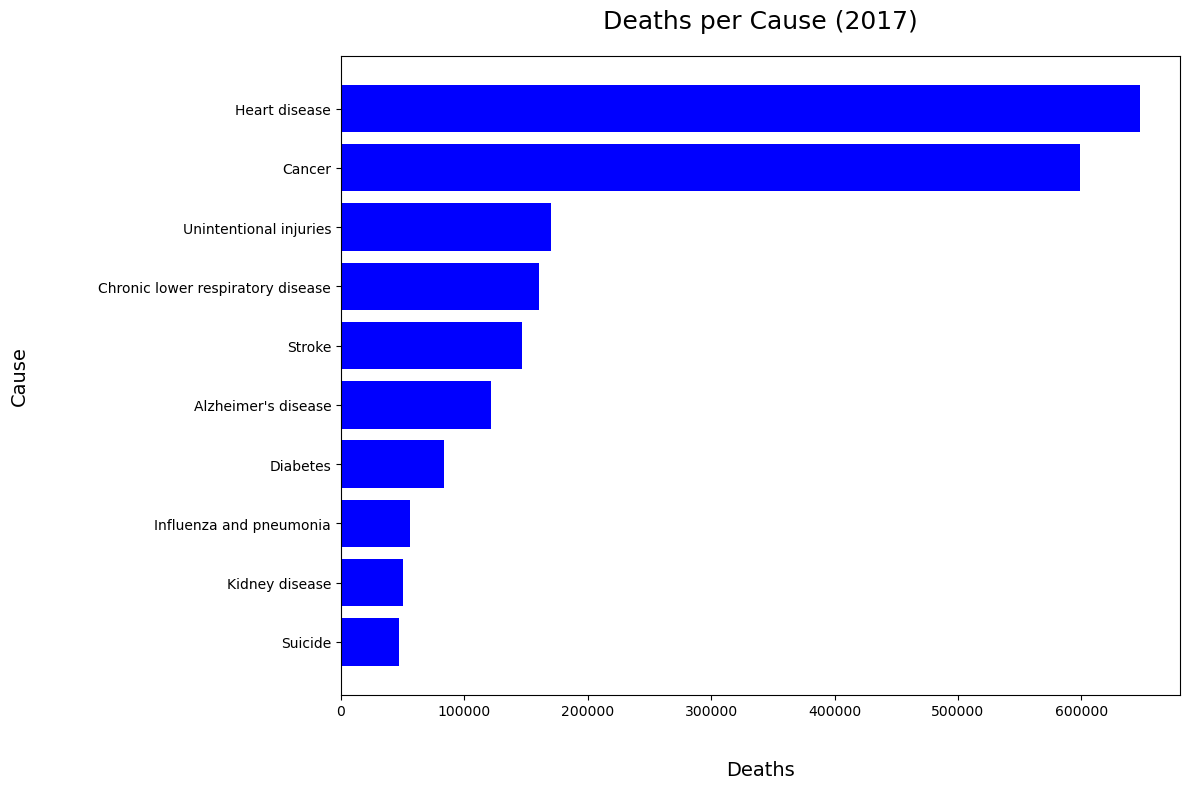

In [20]:
deaths_per_cause_2017 = dict(sorted(deaths_per_cause_2017.items(), key=lambda item: item[1]))

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(list(deaths_per_cause_2017.keys()), list(deaths_per_cause_2017.values()), color='blue')

# Title and labels
plt.title("Deaths per Cause (2017)", fontsize=18, pad=20)
plt.xlabel("Deaths", fontsize=14, labelpad=30)
plt.ylabel("Cause", fontsize=14, labelpad=50)

plt.tight_layout()
plt.show()

##### Graph for deaths per year

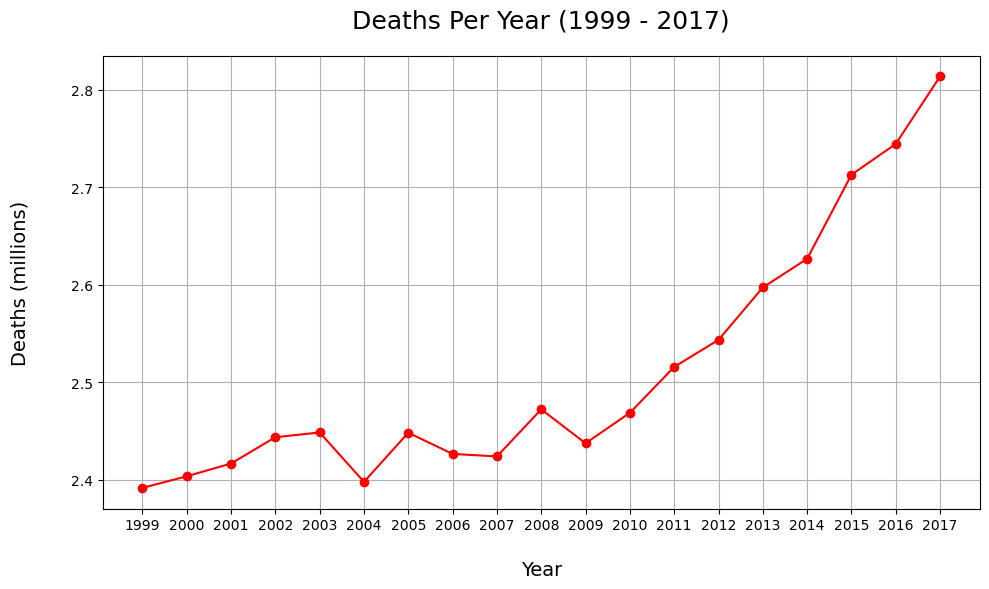

In [21]:
deaths_per_year = dict(sorted(deaths_per_year.items()))
years = list(deaths_per_year.keys())
deaths = list(deaths_per_year.values())

# line plot
plt.figure(figsize=(10, 6))
plt.plot(years, deaths, marker='o', linestyle='-', color='r')

# Titles and labels
plt.title('Deaths Per Year (1999 - 2017)', fontsize=18, pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Deaths (millions)', fontsize=14, labelpad=30)

# Format y-axis labels to show in millions
formatter = FuncFormatter(lambda x, _: f'{x * 1e-6:.1f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(years)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Graph for deaths per year in NJ

In [ ]:
nj_yearly_deaths = dict(sorted(nj_yearly_deaths.items()))
years = list(nj_yearly_deaths.keys())
deaths = list(nj_yearly_deaths.values())

plt.figure(figsize=(10, 6))
plt.plot(years, deaths, marker='o', linestyle='-', color='purple')

plt.title('NJ Deaths Per Year (1999 - 2017)', fontsize=18, pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Deaths', fontsize=14, labelpad=30)

plt.xticks(years)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Graph for deaths per year from heart disease in NJ

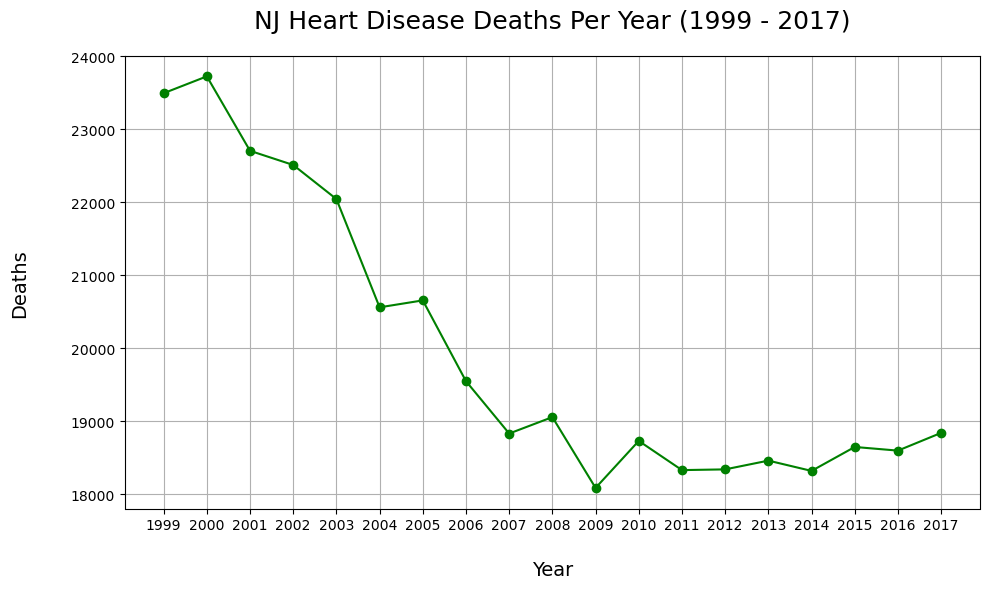

In [23]:
nj_leadingcause_deaths = dict(sorted(nj_leadingcause_deaths.items()))
years = list(nj_leadingcause_deaths.keys())
deaths = list(nj_leadingcause_deaths.values())

plt.figure(figsize=(10, 6))
plt.plot(years, deaths, marker='o', linestyle='-', color='g')

plt.title('NJ Heart Disease Deaths Per Year (1999 - 2017)', fontsize=18, pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Deaths', fontsize=14, labelpad=30)

plt.xticks(years)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Graph for deaths per year from cancer in NJ

In [ ]:
nj_cancer_deaths = dict(sorted(nj_cancer_deaths.items()))
years = list(nj_cancer_deaths.keys())
deaths = list(nj_cancer_deaths.values())

plt.figure(figsize=(10, 6))
plt.plot(years, deaths, marker='o', linestyle='-', color='g')

plt.title('NJ Cancer Deaths Per Year (1999 - 2017)', fontsize=18, pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Deaths', fontsize=14, labelpad=30)

plt.xticks(years)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Graph for deaths per year in California

In [ ]:
state_most_deaths = dict(sorted(state_most_deaths.items()))
years = list(state_most_deaths.keys())
deaths = list(state_most_deaths.values())

plt.figure(figsize=(10, 6))
plt.plot(years, deaths, marker='o', linestyle='-', color='r')

plt.title('California Deaths Per Year (1999 - 2017)', fontsize=18, pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Deaths', fontsize=14, labelpad=30)

plt.xticks(years)
plt.grid(True)
plt.tight_layout()
plt.show()

### Prediction Model

##### Prediction for total deaths over time (US)

RMSE: 59428.67036249851
R² Score: 0.7702521806936778


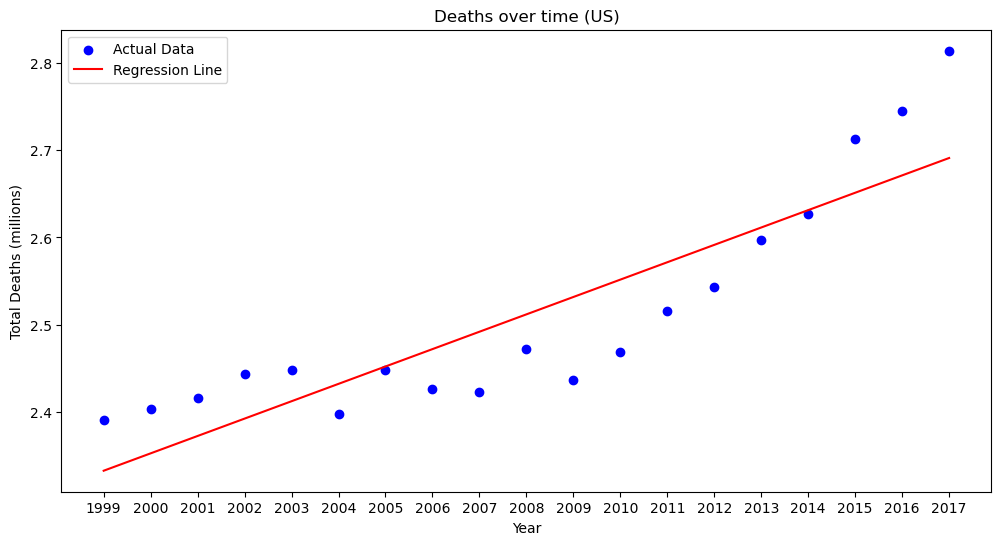

Predicted deaths for 2025 - 2027: [2849764 2869631 2889498]


In [26]:
years = np.array(list(deaths_per_year.keys())).reshape(-1, 1)
years = years.astype(int)
deaths = np.array(list(deaths_per_year.values()))

# Training
model = LinearRegression()
model.fit(years, deaths)

# Predict on training data
predicted_deaths = model.predict(years)

# Evaluation
rmse = root_mean_squared_error(deaths, predicted_deaths)
r2 = r2_score(deaths, predicted_deaths)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(years, deaths, color='blue', label='Actual Data')
plt.plot(years, predicted_deaths, color='red', label='Regression Line')
plt.xlabel("Year")
plt.ylabel("Total Deaths (millions)")
plt.title("Deaths over time (US)")

# Format y-axis labels to show in millions
formatter = FuncFormatter(lambda x, _: f'{x * 1e-6:.1f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Format x-axis to show years without decimals
plt.xticks(np.arange(int(np.min(years)), int(np.max(years)) + 1, 1))

plt.legend()
plt.show()

# Prediction
future_years = np.array([2025, 2026, 2027]).reshape(-1, 1)
future_predictions = model.predict(future_years)
future_predictions = np.round(future_predictions).astype(int)
print("Predicted deaths for 2025 - 2027:", future_predictions)

##### Prediction for heart disease deaths over time in NJ

RMSE: 916.2206123166964
R² Score: 0.7661587542742649


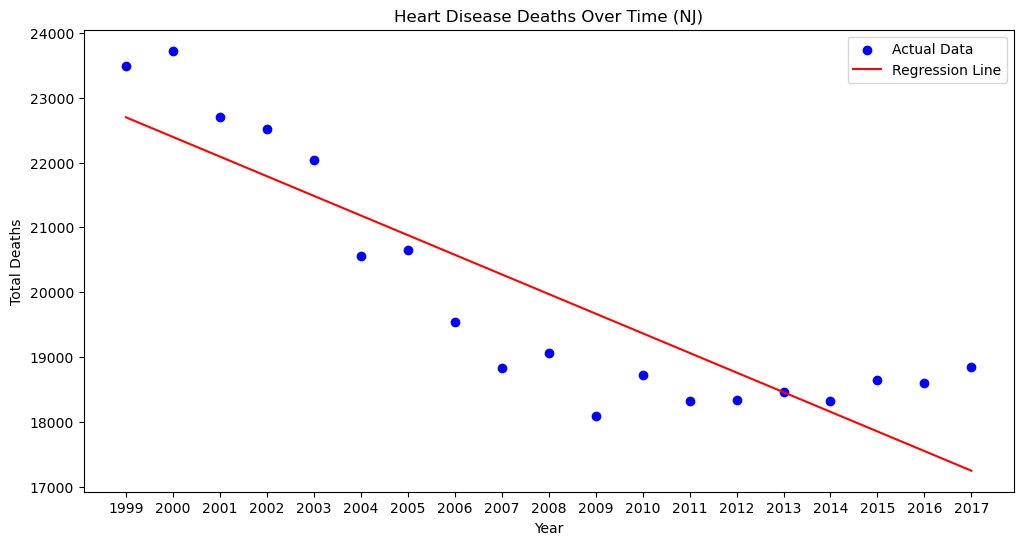

Predicted deaths for 2025-2027: [14825 14522 14219]


In [27]:
years = np.array(list(nj_leadingcause_deaths.keys())).reshape(-1, 1)
years = years.astype(int)
deaths = np.array(list(nj_leadingcause_deaths.values()))

model = LinearRegression()
model.fit(years, deaths)

predicted_deaths = model.predict(years)

rmse = root_mean_squared_error(deaths, predicted_deaths)
r2 = r2_score(deaths, predicted_deaths)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(12, 6))
plt.scatter(years, deaths, color='blue', label='Actual Data')
plt.plot(years, predicted_deaths, color='red', label='Regression Line')
plt.xlabel("Year")
plt.ylabel("Total Deaths")
plt.title("Heart Disease Deaths Over Time (NJ)")
plt.xticks(np.arange(int(np.min(years)), int(np.max(years)) + 1, 1))
plt.legend()
plt.show()

future_years = np.array([2025, 2026, 2027]).reshape(-1, 1)
future_predictions = model.predict(future_years)
future_predictions = np.round(future_predictions).astype(int)
print("Predicted deaths for 2025-2027:", future_predictions)

##### Prediction for cancer deaths over time in NJ

RMSE: 203.54294003850956
R² Score: 0.9046646788360946


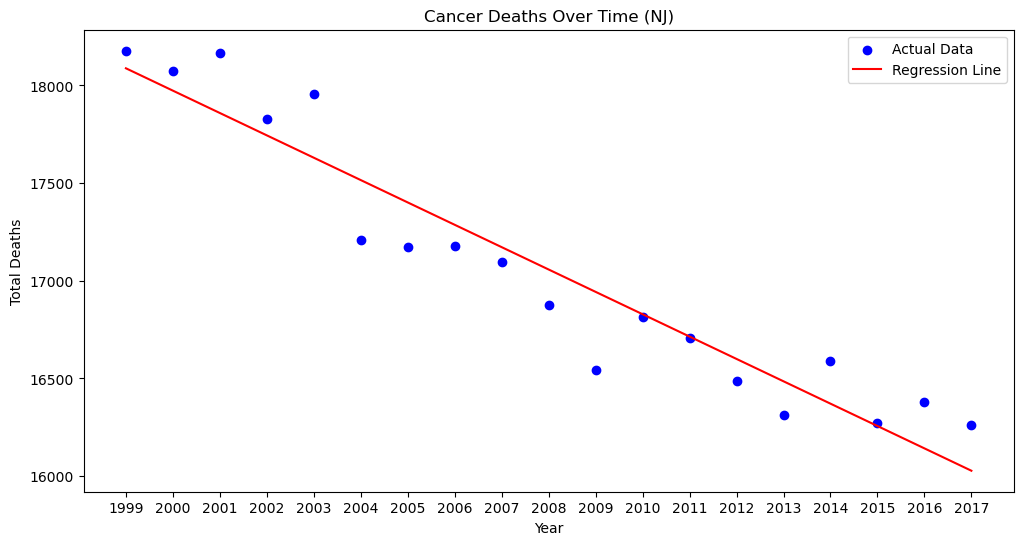

Predicted deaths for 2025-2027: [15112 14997 14883]


In [28]:
years = np.array(list(nj_cancer_deaths.keys())).reshape(-1, 1)
years = years.astype(int)
deaths = np.array(list(nj_cancer_deaths.values()))

model = LinearRegression()
model.fit(years, deaths)

predicted_deaths = model.predict(years)

rmse = root_mean_squared_error(deaths, predicted_deaths)
r2 = r2_score(deaths, predicted_deaths)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(12, 6))
plt.scatter(years, deaths, color='blue', label='Actual Data')
plt.plot(years, predicted_deaths, color='red', label='Regression Line')
plt.xlabel("Year")
plt.ylabel("Total Deaths")
plt.title("Cancer Deaths Over Time (NJ)")
plt.xticks(np.arange(int(np.min(years)), int(np.max(years)) + 1, 1))
plt.legend()
plt.show()

future_years = np.array([2025, 2026, 2027]).reshape(-1, 1)
future_predictions = model.predict(future_years)
future_predictions = np.round(future_predictions).astype(int)
print("Predicted deaths for 2025-2027:", future_predictions)